In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("seaborn-v0_8")

In [20]:
#Portfolio stocks data

In [21]:
tickers=["AAPL","JPM","PG"]
weights=np.array([1/3,1/3,1/3])
for t in tickers:
    data=yf.download(tickers,start="2010-1-1",auto_adjust=False)['Adj Close']

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


In [22]:
returns=data.pct_change().dropna()
returns

Ticker,AAPL,JPM,PG
Date,,,
2010-01-05,0.001728,0.019370,0.000328
2010-01-06,-0.015906,0.005494,-0.004743
2010-01-07,-0.001849,0.019809,-0.005423
2010-01-08,0.006648,-0.002456,-0.001322
2010-01-11,-0.008821,-0.003357,-0.003971
...,...,...,...
2025-12-03,-0.007128,0.013804,0.005828
2025-12-04,-0.012141,0.012719,-0.009202
2025-12-05,-0.006840,-0.003353,-0.013140


In [23]:
portfolio_returns=(returns*weights).sum(axis=1)
portfolio_returns

Date
2010-01-05    0.007142
2010-01-06   -0.005052
2010-01-07    0.004179
2010-01-08    0.000957
2010-01-11   -0.005383
                ...   
2025-12-03    0.004168
2025-12-04   -0.002875
2025-12-05   -0.007778
2025-12-08   -0.012758
2025-12-09   -0.013289
Length: 4008, dtype: float64

In [24]:
#Benchmark data

In [25]:
ticker=["^GSPC"]
for t in ticker:
    benchmark=yf.download(ticker,start="2010-1-1",auto_adjust=False)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [26]:
benchmark.tail()

Ticker,^GSPC
Date,
2025-12-03,6849.720215
2025-12-04,6857.120117
2025-12-05,6870.399902
2025-12-08,6846.509766
2025-12-09,6840.509766


In [27]:
benchmark_returns=benchmark.pct_change().dropna()
benchmark_returns

Ticker,^GSPC
Date,
2010-01-05,0.003116
2010-01-06,0.000546
2010-01-07,0.004001
2010-01-08,0.002882
2010-01-11,0.001747
...,...
2025-12-03,0.002980
2025-12-04,0.001080
2025-12-05,0.001937


In [28]:
# Aligning dates of portfolio returns and benchmark returns

In [29]:
benchmark_returns = benchmark_returns.iloc[:, 0] 
portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join="inner")
print(portfolio_returns.shape)
print(benchmark_returns.shape)

(4008,)
(4008,)


In [30]:
cum_ret = (1 + portfolio_returns).cumprod()
cum_ret

Date
2010-01-05     1.007142
2010-01-06     1.002054
2010-01-07     1.006242
2010-01-08     1.007205
2010-01-11     1.001783
                ...    
2025-12-03    15.231862
2025-12-04    15.188074
2025-12-05    15.069945
2025-12-08    14.877677
2025-12-09    14.679975
Length: 4008, dtype: float64

In [31]:
# Risk Adjusted Metrics Portfolio

In [32]:
def sharpe(r, rf=0):
    return (r.mean() - rf) / r.std() * np.sqrt(252)

def sortino(r, rf=0):
    downside = r[r < 0].std()
    return (r.mean() - rf) / downside * np.sqrt(252)

def max_drawdown(cum):
    return ((cum / cum.cummax()) - 1).min()

def treynor_ratio(port, bench, rf=0):
    beta = np.cov(port, bench)[0][1] / np.var(bench)
    return (port.mean() * 252 - rf) / beta

def information_ratio(port, bench):
    excess = port - bench
    te = excess.std() * np.sqrt(252)
    return (excess.mean() * 252) / te

def m_squared(port, bench, rf=0):
    sharpe_p = sharpe(port, rf)
    bench_vol = bench.std() * np.sqrt(252)
    return sharpe_p * bench_vol + rf


In [33]:
metrics = {
    "Annual Return": portfolio_returns.mean() * 252,
    "Annual Volatility": portfolio_returns.std() * np.sqrt(252),
    "Sharpe Ratio": sharpe(portfolio_returns),
    "Sortino Ratio": sortino(portfolio_returns),
    "Max Drawdown": max_drawdown(cum_ret),
    "Treynor Ratio": treynor_ratio(portfolio_returns, benchmark_returns),
    "Information Ratio": information_ratio(portfolio_returns, benchmark_returns),
    "M-Squared": m_squared(portfolio_returns, benchmark_returns)
}

pd.DataFrame(metrics, index=["Portfolio"])


,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Treynor Ratio,Information Ratio,M-Squared
Portfolio,0.186239,0.18594,1.001606,1.325546,-0.322658,0.199161,0.634019,0.173789


In [34]:
benchmark_metrics = {
    "Annual Return": benchmark_returns.mean() * 252,
    "Annual Volatility": benchmark_returns.std() * np.sqrt(252),
    "Sharpe Ratio": sharpe(benchmark_returns),
    "Sortino Ratio": sortino(benchmark_returns),
    "Max Drawdown": max_drawdown((1 + benchmark_returns).cumprod()),
    "Treynor Ratio": treynor_ratio(benchmark_returns, benchmark_returns),   # Beta = 1, returns = RB
    "Information Ratio": np.nan,  # IR not applicable for benchmark
    "M-Squared": benchmark_returns.mean() * 252   # M² = benchmark return for benchmark
}

pd.DataFrame(benchmark_metrics, index=["Benchmark"])


,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Treynor Ratio,Information Ratio,M-Squared
Benchmark,0.128169,0.17351,0.738684,0.909671,-0.33925,0.128137,NaN,0.128169


In [35]:
# Portfolio Returns vs Benchmark Retruns Plot

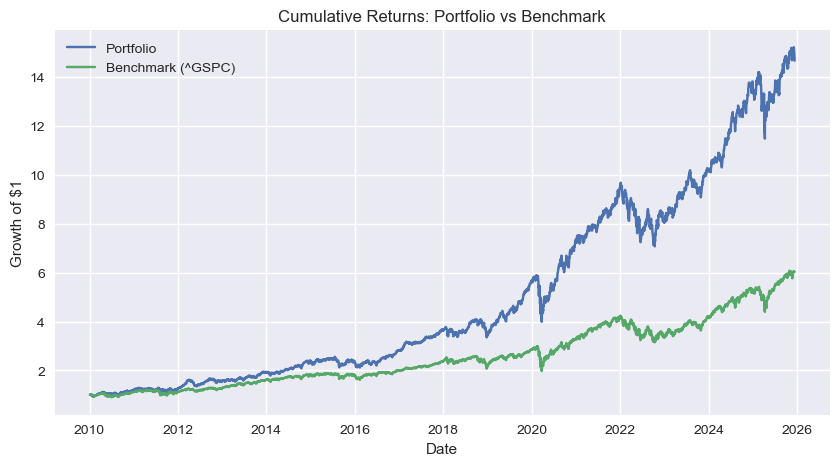

In [36]:
#cumulative returns
cum_portfolio = (1 + portfolio_returns).cumprod()
cum_benchmark = (1 + benchmark_returns).cumprod()


plt.figure(figsize=(10,5))
plt.plot(cum_portfolio, label="Portfolio")
plt.plot(cum_benchmark, label="Benchmark (^GSPC)")
plt.title("Cumulative Returns: Portfolio vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.show()
